In [1]:
using Plots; gr()
using Reproduce
using FileIO
using Statistics
using ProgressMeter
using DataStructures
# using JLD2
using RollingFunctions
data_home = "../working_results/final_runs_with_acc"

"../working_results/final_runs_with_acc"

In [2]:
tol_muted = parse.(Colorant, ("#88CCEE", "#44AA99", "#117733", "#332288", "#DDCC77", "#999933","#CC6677", "#882255", "#AA4499", "#DDDDDD"))

(RGB{N0f8}(0.533,0.8,0.933), RGB{N0f8}(0.267,0.667,0.6), RGB{N0f8}(0.067,0.467,0.2), RGB{N0f8}(0.2,0.133,0.533), RGB{N0f8}(0.867,0.8,0.467), RGB{N0f8}(0.6,0.6,0.2), RGB{N0f8}(0.8,0.4,0.467), RGB{N0f8}(0.533,0.133,0.333), RGB{N0f8}(0.667,0.267,0.6), RGB{N0f8}(0.867,0.867,0.867))

In [3]:
function get_setting(ic, clean_func)

    diff_dict = diff(ic)
    
    itms = ic.items
    res = zeros(length(ic.items))
    for (itm_idx, itm) ∈ enumerate(itms)
        try
            res[itm_idx] = clean_func(
                FileIO.load(joinpath(itm.folder_str, "results.jld2")))
            if isnan(res[itm_idx])
                res[itm_idx] = Inf
            end
        catch
            println("error: $(itm.folder_str)")
            res[itm_idx] = Inf
        end
    end
    μ = mean(res)
    if isinf(μ)
        μ = 10000
    end
    σ = std(res)./sqrt(length(itms))
    if isnan(σ)
        σ = 0
    end
    
    return μ, σ
end

function get_best_setting(ic, sweep_params, clean_comp_func, clean_ret_func)

    diff_dict = diff(ic)

    μ_comp = zeros(length(diff_dict[sweep_param]))
    μ_ret = []
    σ_ret = []
    
    for (swprm_idx, swprm) ∈ enumerate(Iterators.diff_dict[sweep_param])
        sub_ic = search(ic, Dict(sweep_param=>swprm))
        res = zeros(length(sub_ic.items))
        
        res_ret = []
        
        for (itm_idx, itm) ∈ enumerate(sub_ic.items)
            try
                d = FileIO.load(joinpath(itm.folder_str, "results.jld2"))
                res[itm_idx] = clean_comp_func(d)
                push!(res_ret, clean_ret_func(d))
                if isnan(res[itm_idx])
                    res[itm_idx] = Inf
                end
            catch
                println("error: $(itm.folder_str)")
                res[itm_idx] = Inf
            end
        end
        μ_comp[swprm_idx] = mean(res)
        push!(μ_ret, mean(res_ret))
        push!(σ_ret, std(res_ret)./sqrt(length(sub_ic.items)))
    end
    min_idx = findmin(μ_comp)
    diff_dict[sweep_param][min_idx[2]], (μ_ret[min_idx[2]], σ_ret[min_idx[2]])
end

get_best_setting (generic function with 1 method)

# Compass World - setup

In [4]:
ic_compassworld_rnn_adam = ItemCollection(joinpath(data_home, "final_compworld_rnn_adam/data"));
ic_compassworld_rnn_aux_task_adam = ItemCollection(joinpath(data_home, "final_compworld_rnn_aux_task_adam/data"));
ic_compassworld_gvfn_adam = ItemCollection(joinpath(data_home, "final_compworld_gvfn_adam/data"));
ic_compassworld_forecast_adam = ItemCollection(joinpath(data_home, "final_compworld_forecast_adam/data"));

ic_compassworld_rnn = ItemCollection(joinpath(data_home, "final_compworld_rnn/data"));
ic_compassworld_rnn_aux_task = ItemCollection(joinpath(data_home, "final_compworld_rnn_aux_task/data"));
ic_compassworld_gvfn = ItemCollection(joinpath(data_home, "final_compworld_gvfn/data"));
ic_compassworld_forecast = ItemCollection(joinpath(data_home, "final_compworld_forecast/data"));

In [5]:
function plot_trunc_comp_world(ic, lp; clean_func=(d)->d["results"]["end"], lp_sub_set = nothing, line_settings=nothing, plt=nothing, kwargs...)
    diff_dict = diff(ic)
#     plt = nothing
    
    if line_settings == nothing
        line_settings = Dict{typeof(diff_dict[lp][1]), Any}()
        for lp_set ∈ diff_dict[lp]
            line_settings[lp_set] = Dict{Symbol, Any}(
                :label => lp_set
            )
        end
    end
    
    for horde ∈ (lp_sub_set == nothing ? diff_dict[lp] : lp_sub_set)
        sub_ic = search(ic, Dict(lp=>horde))
        μ = zeros(length(diff(sub_ic)["truncation"]))
        σ = zeros(length(diff(sub_ic)["truncation"]))
        for (idx, trunc) ∈ enumerate(diff(sub_ic)["truncation"])
            μ[idx], σ[idx] = get_setting(search(sub_ic, Dict("truncation"=>trunc)), clean_func)
        end
        if plt == nothing
            plt = plot(diff(sub_ic)["truncation"], μ, yerr=σ; label=horde, line_settings[horde]..., kwargs...)
        else
            plot!(plt, diff(sub_ic)["truncation"], μ, yerr=σ; label=horde, line_settings[horde]..., kwargs...)
        end
    end
    plt
end

function plot_trunc_comp_world(ic_rnn, ic_gvfn, ic_forecast; kwargs...)
    plt = plot_trunc_comp_world(ic_gvfn, "gvfn-horde"; kwargs...)
    plot_trunc_comp_world(ic_rnn, "cell"; plt=plt, kwargs...)
    plot_trunc_comp_world(ic_forecast, "cell"; lp_sub_set=["ARNNCell"], plt=plt, kwargs...)
    return plt
end

plot_trunc_comp_world (generic function with 2 methods)

In [56]:
function plot_lc_comp_world(ic, lp::String; clean_func=(d)->d["results"]["lc"][1,:], lp_sub_set = nothing, line_settings=nothing, plt=nothing, kwargs...)
    diff_dict = diff(ic)
#     plt = nothing
    
    if line_settings == nothing
        line_settings = Dict{typeof(diff_dict[lp][1]), Any}()
        for lp_set ∈ diff_dict[lp]
            line_settings[lp_set] = Dict{Symbol, Any}(
                :label => lp_set
            )
        end
    end

    for horde ∈ (lp_sub_set == nothing ? diff_dict[lp] : lp_sub_set)
        sub_ic = search(ic, Dict(lp=>horde))
        res = []
#         println(length(sub_ic.items))
        for itm ∈ sub_ic.items
            push!(res, clean_func(FileIO.load(joinpath(itm.folder_str, "results.jld2"))))
        end
        line = mean(res)
#         @show size(line)
        line_σ = std(res) ./ sqrt(length(res))
        if plt == nothing
            plt = plot(line, ribbon=line_σ; label=horde, line_settings[horde]..., kwargs...)
        else
            plot!(plt, line, ribbon=line_σ; label=horde, line_settings[horde]..., kwargs...)
        end
    end
    plt
end

function plot_lc_single_trunc(ic_gvfn_rw, ic_rnn_rw, ic_fore_rw=nothing, trunc=1; line_settings=nothing, kwargs...)
    plt = plot_lc_comp_world(search(ic_gvfn_rw, Dict("truncation"=>trunc)), "gvfn-horde"; line_settings=line_settings, kwargs...)
    plot_lc_comp_world(search(ic_rnn_rw, Dict("truncation"=>trunc)), "cell"; line_settings=line_settings, plt=plt, kwargs...)
    plot_lc_comp_world(search(ic_fore_rw, Dict("truncation"=>trunc)), "cell"; lp_sub_set=["ARNNCell"], line_settings=line_settings, plt=plt, kwargs...) 
    plt
end

function plot_legend(line_settings)
    plt = plot(ticks=nothing, border=:none)
    for k in keys(line_settings)
        plot!(plt, rand(1); line_settings[k]...)
    end
    plt
end

function plot_lc_trunc_comp_world(ic_gvfn_rw, ic_rnn_rw, ic_fore_rw=nothing; seperate_legend=false, line_settings=nothing, kwargs...)
    plts = []
    for trunc ∈ diff(ic_gvfn_rw)["truncation"]
        plt = plot_lc_comp_world(search(ic_gvfn_rw, Dict("truncation"=>trunc)), "gvfn-horde"; line_settings=line_settings, title="Truncation: $(trunc)", kwargs...)
        plot_lc_comp_world(search(ic_rnn_rw, Dict("truncation"=>trunc)), "cell"; line_settings=line_settings, plt=plt, kwargs...)
        plot_lc_comp_world(search(ic_fore_rw, Dict("truncation"=>trunc)), "cell"; line_settings=line_settings, plt=plt, kwargs...) 
        push!(plts, plt)
    end
    if seperate_legend
        plt = plot_legend(line_settings)
        push!(plts,plt)
    end
    
    plot(plts..., size=(800,800))
end

plot_lc_trunc_comp_world (generic function with 2 methods)

# Compass World sensitivity to truncation - 1

In [115]:
plot_settings = Dict(
    :tickdir=>:out, 
    :grid=>false, 
    :lw=>3, 
    :legend=>false, 
    :minorticks=>2, 
    :tickfont => font(18, "Times"),
    :ylim=>(0.0, 0.25)
#     :xlabel=>"Truncation",
#     :guidefont=> font(16, "TimesNewRoman")
#     :xlabelfont=> font(16, "TimesNewRoman")
)

function plot_comp_figure_1(ic_rnn, ic_gvfn, ic_rnn_at; line_settings=Dict(), kwargs...)
    plt = plot_trunc_comp_world(ic_gvfn, "gvfn-horde"; lp_sub_set = ["gammas_aj_term"], line_settings=line_settings, kwargs...)
    plot_trunc_comp_world(ic_rnn, "cell"; plt=plt, line_settings=line_settings, kwargs...)
    plot_trunc_comp_world(ic_rnn_at, "cell"; plt=plt, line_settings=line_settings, ls=:dash, kwargs...)
#     plot_trunc_comp_world(ic_forecast, "cell"; lp_sub_set=["ARNNCell"], plt=plt, kwargs...)
    return plt
end

line_settings = Dict(
    "forward"=>Dict(:color=>tol_muted[1]),
    "gammas_aj"=>Dict(:color=>tol_muted[7]),
    "gammas_aj_term"=>Dict(:color=>tol_muted[8]),
    "rafols"=>Dict(:color=>tol_muted[4]),
    "ARNN"=>Dict(:color=>tol_muted[3]),
    "ARNNCell"=>Dict(:color=>tol_muted[3], :ls=>:dash),
    "LSTM"=>Dict(:color=>tol_muted[5]),
    "LSTMCell"=>Dict(:color=>tol_muted[5], :ls=>:dash),
    "GRU"=>Dict(:color=>tol_muted[6]),
    "GRUCell"=>Dict(:color=>tol_muted[6], :ls=>:dash)
)

plot_comp_figure_1(
    ic_compassworld_rnn, ic_compassworld_gvfn, search(ic_compassworld_rnn_aux_task, Dict("at-horde"=>("gammas_aj_term")));
    clean_func=(d)->d["results"]["end"], 
    line_settings=line_settings, 
    plot_settings...)

savefig("compworld_trunc_sense.pdf")

In [117]:
diff(ic_compassworld_rnn)

Dict{String,Array} with 4 entries:
  "alpha"      => [0.0444444, 0.0666667, 0.1, 0.15, 0.225, 0.3375]
  "truncation" => [1, 4, 8, 12, 16, 24, 32]
  "seed"       => [11, 12, 13, 14, 15, 16, 17, 18, 19, 20  …  31, 32, 33, 34, 3…
  "cell"       => ["ARNN", "GRU", "LSTM"]

In [116]:
plot_settings = Dict(
    :tickdir=>:out, 
    :grid=>false, 
    :lw=>3, 
    :legend=>false, 
    :minorticks=>2, 
    :tickfont => font(18, "Times"),
    :ylim=>(0.0, 0.20)
)

plot_comp_figure_1(
    ic_compassworld_rnn_adam, ic_compassworld_gvfn_adam, search(ic_compassworld_rnn_aux_task_adam, Dict("at-horde"=>("gammas_aj_term")));
    clean_func=(d)->d["results"]["end"], 
    line_settings=line_settings, 
    plot_settings...)

savefig("compworld_trunc_sense_adam.pdf")

# Compass World Learning Curves - 1

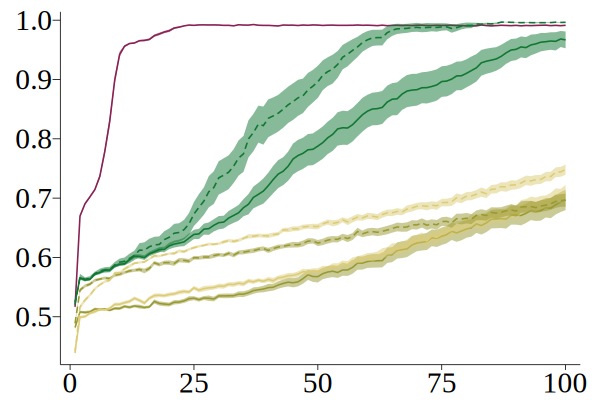

In [120]:
plot_settings = Dict(
    :tickdir=>:out, 
    :grid=>false, 
    :lw=>2, 
    :legend=>false, 
    :tickdir=>:out,
#     :minorticks=>2, 
#     :ylim => (0.2, 1.0),
    :titlefont=> font(14, "Times"),
    :tickfont => font(18, "Times"))

line_settings = Dict(
    "forward"=>Dict(:color=>tol_muted[1]),
    "gammas_aj"=>Dict(:color=>tol_muted[7]),
    "gammas_aj_term"=>Dict(:color=>tol_muted[8]),
    "rafols"=>Dict(:color=>tol_muted[4]),
    "ARNN"=>Dict(:color=>tol_muted[3]),
    "ARNNCell"=>Dict(:color=>tol_muted[3], :ls=>:dash),
    "LSTM"=>Dict(:color=>tol_muted[5]),
    "LSTMCell"=>Dict(:color=>tol_muted[5], :ls=>:dash),
    "GRU"=>Dict(:color=>tol_muted[6]),
    "GRUCell"=>Dict(:color=>tol_muted[6], :ls=>:dash)
)

function plot_lc_firgure_1(ic_gvfn, ic_rnn, ic_rnn_at, trunc=1; line_settings=nothing, kwargs...)
    plt = plot_lc_comp_world(search(ic_gvfn, Dict("truncation"=>trunc)), "gvfn-horde"; lp_sub_set=["gammas_aj_term"], line_settings=line_settings, kwargs...)
    plot_lc_comp_world(search(ic_rnn, Dict("truncation"=>trunc)), "cell"; line_settings=line_settings, plt=plt, kwargs...)
    plot_lc_comp_world(search(ic_rnn_at, Dict("truncation"=>trunc)), "cell"; line_settings=line_settings, ls=:dash, plt=plt, kwargs...)
    plt
end

smooth_accuracy_clean_func(d, n) = mean(reshape(d["results"]["acc"][1,:], :, n), dims=1)[1,:]

plot_lc_firgure_1(
    ic_compassworld_gvfn, 
    ic_compassworld_rnn, 
    search(ic_compassworld_rnn_aux_task, Dict("at-horde"=>("gammas_aj_term"))), 
    4; 
    clean_func=(d)->smooth_accuracy_clean_func(d, 100),
    line_settings=line_settings, 
    plot_settings...)

# savefig("compworld_lc_4.pdf")

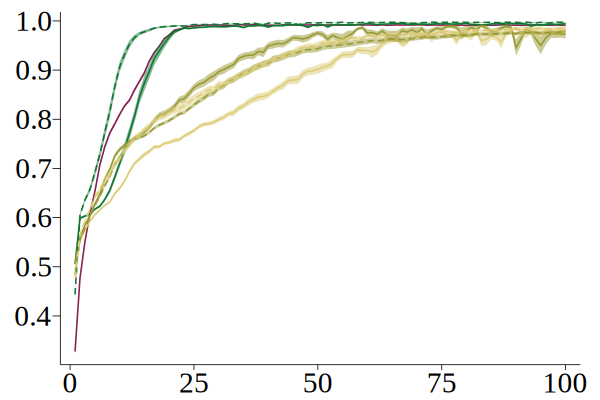

In [121]:
plot_settings = Dict(
    :tickdir=>:out, 
    :grid=>false, 
    :lw=>2, 
    :legend=>false, 
    :tickdir=>:out,
#     :minorticks=>2, 
#     :ylim => (0.2, 1.0),
    :titlefont=> font(14, "Times"),
    :tickfont => font(18, "Times"))

plot_lc_firgure_1(
    ic_compassworld_gvfn_adam, ic_compassworld_rnn_adam, ic_compassworld_rnn_aux_task_adam, 4; 
    clean_func=(d)->smooth_accuracy_clean_func(d, 100),
    line_settings=line_settings, 
    plot_settings...)
# savefig("compworld_lc_4_adam.pdf")

# Compass World bad GVFNs

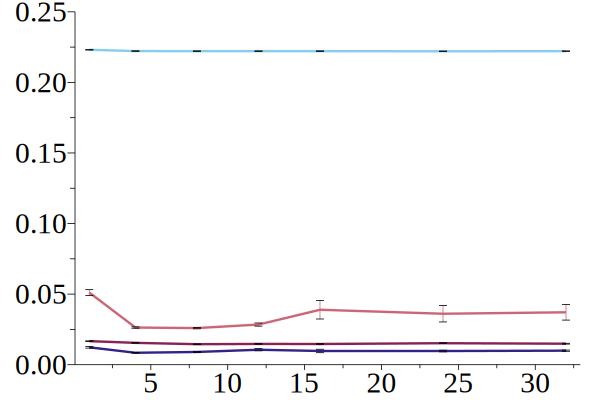

In [40]:
plot_settings = Dict(
    :tickdir=>:out, 
    :grid=>false, 
    :lw=>3, 
    :legend=>false, 
    :minorticks=>2, 
    :tickfont => font(18, "Times"),
    :ylim=>(0.0, 0.25)
#     :xlabel=>"Truncation",
#     :guidefont=> font(16, "TimesNewRoman")
#     :xlabelfont=> font(16, "TimesNewRoman")
)

function plot_comp_figure_2(ic_rnn, ic_gvfn, ic_rnn_at; line_settings=Dict(), kwargs...)
    plt = plot_trunc_comp_world(ic_gvfn, "gvfn-horde"; line_settings=line_settings, kwargs...)
#     plot_trunc_comp_world(ic_rnn, "cell"; lp_sub_set=["ARNN"], plt=plt, line_settings=line_settings, kwargs...)
#     plot_trunc_comp_world(ic_rnn_at, "cell"; plt=plt, line_settings=line_settings, ls=:dash, kwargs...)
#     plot_trunc_comp_world(ic_forecast, "cell"; lp_sub_set=["ARNNCell"], plt=plt, kwargs...)
    return plt
end

line_settings = Dict(
    "forward"=>Dict(:color=>tol_muted[1]),
    "gammas_aj"=>Dict(:color=>tol_muted[7]),
    "gammas_aj_term"=>Dict(:color=>tol_muted[8]),
    "rafols"=>Dict(:color=>tol_muted[4]),
    "ARNN"=>Dict(:color=>tol_muted[3]),
    "ARNNCell"=>Dict(:color=>tol_muted[3], :ls=>:dash),
    "LSTM"=>Dict(:color=>tol_muted[5]),
    "LSTMCell"=>Dict(:color=>tol_muted[5], :ls=>:dash),
    "GRU"=>Dict(:color=>tol_muted[6]),
    "GRUCell"=>Dict(:color=>tol_muted[6], :ls=>:dash)
)

plot_comp_figure_2(
    ic_compassworld_rnn, ic_compassworld_gvfn, search(ic_compassworld_rnn_aux_task, Dict("at-horde"=>("gammas_aj_term")));
    clean_func=(d)->d["results"]["end"], 
    line_settings=line_settings, 
    plot_settings...)

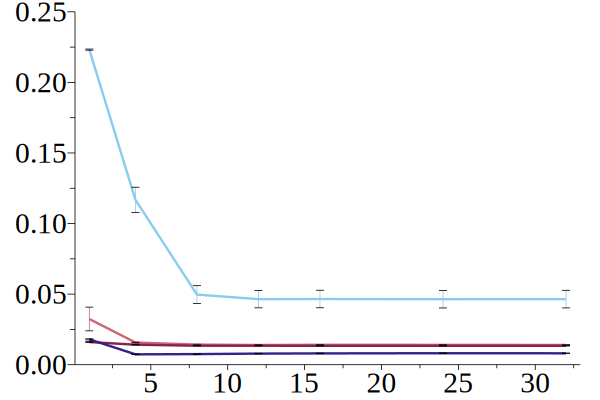

In [44]:
plot_settings = Dict(
    :tickdir=>:out, 
    :grid=>false, 
    :lw=>3, 
    :legend=>false, 
    :minorticks=>2, 
    :tickfont => font(18, "Times"),
    :ylim=>(0.0, 0.25)
#     :xlabel=>"Truncation",
#     :guidefont=> font(16, "TimesNewRoman")
#     :xlabelfont=> font(16, "TimesNewRoman")
)

line_settings = Dict(
    "forward"=>Dict(:color=>tol_muted[1]),
    "gammas_aj"=>Dict(:color=>tol_muted[7]),
    "gammas_aj_term"=>Dict(:color=>tol_muted[8]),
    "rafols"=>Dict(:color=>tol_muted[4]),
    "ARNN"=>Dict(:color=>tol_muted[3]),
    "ARNNCell"=>Dict(:color=>tol_muted[3], :ls=>:dash),
    "LSTM"=>Dict(:color=>tol_muted[5]),
    "LSTMCell"=>Dict(:color=>tol_muted[5], :ls=>:dash),
    "GRU"=>Dict(:color=>tol_muted[6]),
    "GRUCell"=>Dict(:color=>tol_muted[6], :ls=>:dash)
)

plot_comp_figure_2(
    nothing, ic_compassworld_gvfn_adam, nothing;
    clean_func=(d)->d["results"]["end"], 
    line_settings=line_settings, 
    plot_settings...)

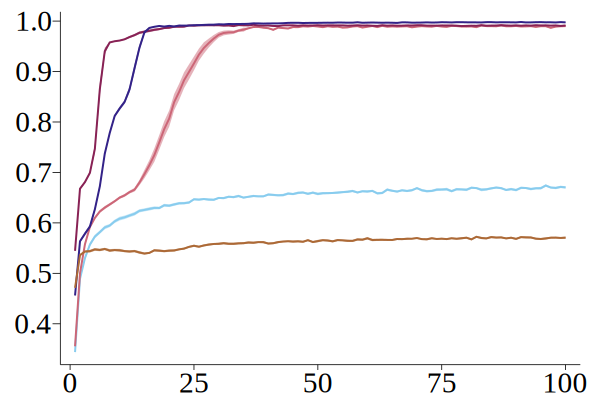

In [104]:
plot_settings = Dict(
    :tickdir=>:out, 
    :grid=>false, 
    :lw=>2.5, 
    :legend=>false, 
    :tickdir=>:out,
#     :minorticks=>2, 
#     :ylim => (0.2, 1.0),
    :titlefont=> font(14, "Times"),
    :tickfont => font(18, "Times"))

line_settings = Dict(
    "forward"=>Dict(:color=>tol_muted[1]),
    "gammas_aj"=>Dict(:color=>tol_muted[7]),
    "gammas_aj_term"=>Dict(:color=>tol_muted[8]),
    "rafols"=>Dict(:color=>tol_muted[4]),
    "ARNN"=>Dict(:color=>tol_muted[3]),
    "ARNNCell"=>Dict(:color=>colorant"#AC6A36"),
    "LSTM"=>Dict(:color=>tol_muted[5]),
    "LSTMCell"=>Dict(:color=>tol_muted[5], :ls=>:dash),
    "GRU"=>Dict(:color=>tol_muted[6]),
    "GRUCell"=>Dict(:color=>tol_muted[6], :ls=>:dash)
)

function plot_lc_firgure_2(ic_gvfn, ic_forecast, trunc=1; line_settings=nothing, plt=nothing, kwargs...)
    plt = plot_lc_comp_world(search(ic_gvfn, Dict("truncation"=>trunc)), "gvfn-horde"; line_settings=line_settings, plt=plt, kwargs...)
#     plot_lc_comp_world(search(ic_rnn, Dict("truncation"=>trunc)), "cell"; line_settings=line_settings, plt=plt, kwargs...)
    plot_lc_comp_world(search(ic_forecast, Dict("truncation"=>trunc)), "cell"; lp_sub_set=["ARNNCell"], line_settings=line_settings,plt=plt, kwargs...)
    plt
end

smooth_accuracy_clean_func(d, n) = mean(reshape(d["results"]["acc"][1,:], :, n), dims=1)[1,:]
smooth_rmsve_clean_func(d, n) = mean(reshape(d["results"]["lc"][1,:], :, n), dims=1)[1,:]

plot_lc_firgure_2(
    ic_compassworld_gvfn, 
    ic_compassworld_forecast,
    8; 
    clean_func=(d)->smooth_accuracy_clean_func(d, 100),
    line_settings=line_settings, 
    plot_settings...)

# savefig("compworld_badgvfs_acc_8.pdf")

In [106]:
plt = plot_lc_firgure_2(
    ic_compassworld_gvfn_adam,
    ic_compassworld_forecast_adam,
    8;
    clean_func=(d)->smooth_accuracy_clean_func(d, 100),
    line_settings=line_settings, 
    plot_settings...)

plot_lc_firgure_2(
    ic_compassworld_gvfn_adam,
    ic_compassworld_forecast_adam,
    1;
    clean_func=(d)->smooth_accuracy_clean_func(d, 100),
    line_settings=line_settings, 
    plt=plt,
    ls=:dash,
    plot_settings...)

savefig("compassworld_fig_2_acc_adam.pdf")

In [107]:
plt = plot_lc_firgure_2(
    ic_compassworld_gvfn,
    ic_compassworld_forecast,
    8;
    clean_func=(d)->smooth_accuracy_clean_func(d, 100),
    line_settings=line_settings, 
    plot_settings...)

plot_lc_firgure_2(
    ic_compassworld_gvfn, 
    ic_compassworld_forecast,
    1;
    clean_func=(d)->smooth_accuracy_clean_func(d, 100),
    line_settings=line_settings, 
    plt=plt,
    ls=:dash,
    plot_settings...)

savefig("compassworld_fig_2_acc.pdf")

In [108]:
plt = plot_lc_firgure_2(
    ic_compassworld_gvfn_adam,
    ic_compassworld_forecast,
    8;
    clean_func=(d)->smooth_rmsve_clean_func(d, 100),
    line_settings=line_settings, 
    plot_settings...)

plot_lc_firgure_2(
    ic_compassworld_gvfn_adam,
    ic_compassworld_forecast_adam,
    1;
    clean_func=(d)->smooth_rmsve_clean_func(d, 100),
    line_settings=line_settings, 
    plt=plt,
    ls=:dash,
    plot_settings...)

savefig("compassworld_fig_2_adam.pdf")

In [109]:
plt = plot_lc_firgure_2(
    ic_compassworld_gvfn,
    ic_compassworld_forecast,
    8;
    clean_func=(d)->smooth_rmsve_clean_func(d, 100),
    line_settings=line_settings, 
    plot_settings...)

plot_lc_firgure_2(
    ic_compassworld_gvfn,
    ic_compassworld_forecast,
    1;
    clean_func=(d)->smooth_rmsve_clean_func(d, 100),
    line_settings=line_settings, 
    plt=plt,
    ls=:dash,
    plot_settings...)

savefig("compassworld_fig_2.pdf")

# Ring world - RGTD